# Boston Housing Case Study  
### Parametric vs. Non-Parametric Regression Methods with Hypothesis Testing

In this notebook, we use the **Boston Housing dataset** ([source](https://www.openml.org/data/download/22102290/dataset)) to explore and compare **parametric** and **non-parametric regression methods** for predicting housing prices.

The analysis covers both **statistical inference** and **machine learning modeling**, allowing us to:
1. Conduct **hypothesis testing** to identify statistically significant features in a parametric model (Linear Regression).  
2. Compare the performance of **parametric** and **non-parametric** methods in predicting median house prices.  
3. Examine how different regression approaches capture relationships between predictors and the target variable (median house value).
4. Evaluate models using metrics such as **Mean Squared Error (MSE)** and **R²**.


### Dataset Features

The Boston Housing dataset contains 13 features describing various characteristics of housing in Boston suburbs:

| Feature | Description |
|---------|-------------|
| **CRIM** | Per capita crime rate by town |
| **ZN** | Proportion of residential land zoned for lots over 25,000 sq.ft. |
| **INDUS** | Proportion of non-retail business acres per town |
| **CHAS** | Charles River dummy variable (1 if tract bounds river; 0 otherwise) |
| **NOX** | Nitric oxides concentration (parts per 10 million) |
| **RM** | Average number of rooms per dwelling |
| **AGE** | Proportion of owner-occupied units built prior to 1940 |
| **DIS** | Weighted distances to five Boston employment centres |
| **RAD** | Index of accessibility to radial highways |
| **TAX** | Full-value property-tax rate per $10,000 |
| **PTRATIO** | Pupil-teacher ratio by town |
| **B** | 1000(Bk - 0.63)² where Bk is the proportion of Black residents by town |
| **LSTAT** | Percentage of lower status of the population |

**Target Variable:** **MEDV** - Median value of owner-occupied homes in $1000's

For more detailed information about the dataset and features, see the [full dataset documentation](https://www.openml.org/d/531).


### Key Concepts

- **Parametric Methods (e.g., Linear Regression):**  
  Assume a predefined functional relationship between predictors and the target variable. 
  Parameters (coefficients) summarize this relationship, making the models simple and interpretable, though potentially less flexible.  

- **Non-Parametric Methods (e.g., K-Nearest Neighbors Regression):**  
  Make no assumptions about the underlying data distribution. Instead, 
  they rely on the proximity of data points to make predictions, 
  allowing for more flexibility but often requiring more data and careful hyperparameter tuning.

# 1. DATA LOADING AND EXPLORATORY ANALYSIS

In this section, we:
- Import the required Python libraries and load the dataset.
- Initial Exploration revealed to understand the dataset structure, quality, and distributions

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

boston = fetch_openml(name="boston", version=1, as_frame=True)
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = pd.to_numeric(boston.target, errors='coerce')

X = df.drop('MEDV', axis=1)
y = df['MEDV']

print("Data shape:", df.shape)
print("Features:", list(X.columns))
print("Target: MEDV")

Data shape: (506, 14)
Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Target: MEDV


Dataset shape: (506, 14)
Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Target: MEDV (Median home value in $1000s)

First few rows:
      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  

Data types:
CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD

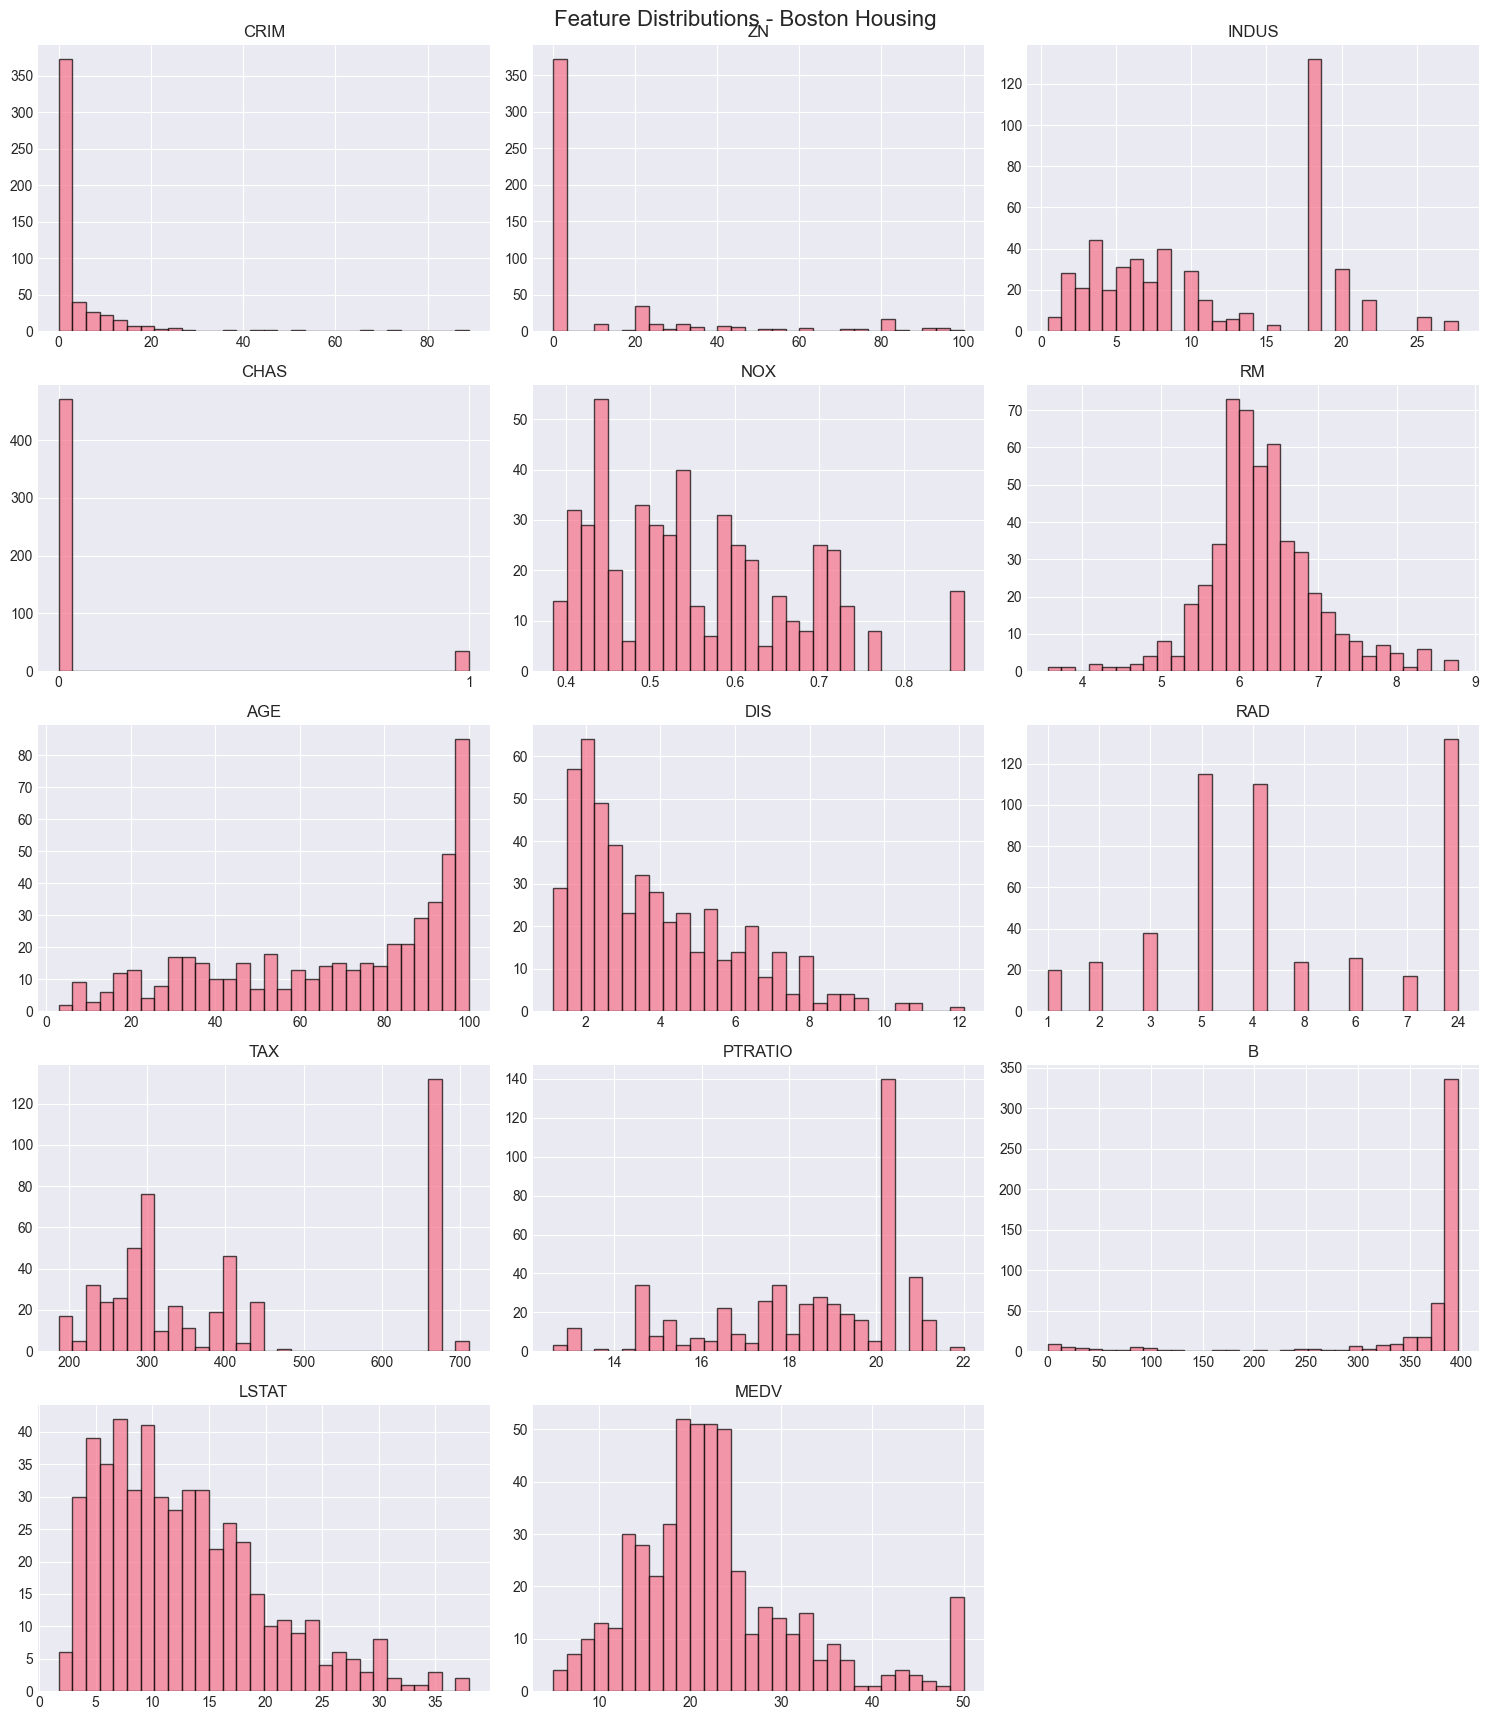

In [16]:

print(f"Dataset shape: {df.shape}")
print(f"Features: {list(boston.feature_names)}")
print("Target: MEDV (Median home value in $1000s)")
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print(f"\nMissing values (total): {df.isnull().sum().sum()}")

print("\n Statistical Summary")

print(df.describe())


# EXPLORATORY DATA ANALYSIS
print("\n Exploratory Data Analysis")

# Distributions
n_cols = len(df.columns)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 3.5))
fig.suptitle('Feature Distributions - Boston Housing', fontsize=16)

axes_flat = axes.flatten()

for idx, col in enumerate(df.columns):
    ax = axes_flat[idx]
    ax.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('')

for idx in range(len(df.columns), len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: distributions.png")

# Correlation matrix
corr = df.corr(numeric_only=True)

print("\nTop correlations with MEDV (target):")
corr_with_target = corr['MEDV'].sort_values(ascending=False)
print(corr_with_target)

print(f"   • Strongest positive correlation: {corr_with_target.index[1]} "
      f"({corr_with_target.iloc[1]:.3f})")
print(f"   • Strongest negative correlation: {corr_with_target.index[-1]} "
      f"({corr_with_target.iloc[-1]:.3f})")

# 2. DATA PREPROCESSING

Before fitting our models, we need to prepare the dataset to ensure that all features are on a comparable scale and that the model can generalize well to unseen data.

Step Involved:
1. **Train–Test Split**  
   We divide the dataset into two parts:
   - **Training set:** Used to fit and train the model.  
   - **Test set:** Used to evaluate the model’s performance on unseen data.  

2. **Feature Standardization**
Since the features in the Boston dataset have different units and scales we standardize them to have:

	- Mean = 0, Standard Deviation = 1

This ensures that:

        - Features contribute equally to the model’s performance.

	    - Distance-based algorithms (like KNN) perform correctly, as they are sensitive to feature magnitudes.

In [17]:

print("\n Train/Test Split")
print("-" * 40)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples:  {X_train.shape[0]}")
print(f"Test samples:      {X_test.shape[0]}")
print(f"Original features: {X_train.shape[1]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}


 Train/Test Split
----------------------------------------
Training samples:  404
Test samples:      102
Original features: 13


## 2. Linear Regression with All Features

In this section, we fit a **baseline parametric model** using **Ordinary Least Squares (OLS) Linear Regression** 

with **all available features** in the Boston Housing dataset.

The goal of this step is to:

- Establish a **baseline performance** before doing any feature selection.

- See how well a **fully specified linear model** (using all predictors) can explain the variation in `MEDV` (median house value).

- Provide a reference point to compare with:
  - A reduced model using only statistically significant features, and  
  - Non-parametric models such as **KNN Regression**.

In [18]:


print("\n Linear Regression with ALL Features")
print("-" * 40)

lr_full = LinearRegression()
lr_full.fit(X_train_scaled, y_train)

y_train_pred_full = lr_full.predict(X_train_scaled)
y_test_pred_full = lr_full.predict(X_test_scaled)

train_mse_full = mean_squared_error(y_train, y_train_pred_full)
test_mse_full = mean_squared_error(y_test, y_test_pred_full)
train_r2_full = r2_score(y_train, y_train_pred_full)
test_r2_full = r2_score(y_test, y_test_pred_full)

print(f"Training MSE (full): {train_mse_full:.4f}")
print(f"Test MSE (full):     {test_mse_full:.4f}")
print(f"Training R² (full):  {train_r2_full:.4f}")
print(f"Test R² (full):      {test_r2_full:.4f}")
print(f"Gap (Test - Train MSE): {test_mse_full - train_mse_full:.4f}")

# Save full-feature model in results
results['Linear (full features)'] = {
    'features': X_train.shape[1],
    'train_mse': train_mse_full,
    'test_mse': test_mse_full,
    'train_r2': train_r2_full,
    'test_r2': test_r2_full,
}


 Linear Regression with ALL Features
----------------------------------------
Training MSE (full): 21.6414
Test MSE (full):     24.2911
Training R² (full):  0.7509
Test R² (full):      0.6688
Gap (Test - Train MSE): 2.6497


## VIF Analysis and Multicollinearity Assessment


VIF (Variance Inflation Factor) measures multicollinearity:
- VIF < 5:  Low multicollinearity
- VIF 5-10: Moderate multicollinearity
- VIF > 10: High multicollinearity

WHY IT MATTERS:
High multicollinearity affects:
1. Coefficient estimates become unstable
2. P-values become unreliable
3. Standard errors increase
4. Difficult to isolate individual feature effects



In [19]:

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) 
                   for i in range(X_train_scaled.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))
print(f"\nMax VIF: {vif_data['VIF'].max():.2f}")
print(f"Features with VIF > 5: {(vif_data['VIF'] > 5).sum()}")

    feature       VIF
9       TAX  8.943301
8       RAD  7.658316
4       NOX  4.469150
7       DIS  4.168578
2     INDUS  3.877855
6       AGE  2.989948
12    LSTAT  2.818045
1        ZN  2.465631
5        RM  1.947809
10  PTRATIO  1.851448
0      CRIM  1.713187
11        B  1.325121
3      CHAS  1.096674

Max VIF: 8.94
Features with VIF > 5: 2


## 3. Linear Regression with Feature Selection (p-Value Based)

In this section, we enhance our baseline linear regression model by 

performing **feature selection using hypothesis testing**.  

The goal is to identify which predictors have a **statistically significant relationship** 

with the target variable (**MEDV**) and then refit the model using only those features.


**HYPOTHESIS** :

For each feature i, we test:

  H₀: βᵢ = 0 (feature has no significant effect on target)

  H₁: βᵢ ≠ 0 (feature has significant effect)

  Using α = 0.05 significance level


In [20]:
X_train_sm = sm.add_constant(X_train)
X_train_sm.dtypes

const       float64
CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
dtype: object

In [ ]:
# Hypothesis Testing — Identifying Significant Predictors


# ============================================================
# TODO:
# ============================================================
# Step 1: Add constant term to training features
X_train_sm = sm.add_constant(X_train_scaled)

# Step 2: Fit OLS model and display summary
ols_model = sm.OLS(y_train, X_train_sm).fit()

print(ols_model.summary())

# TODO: 
pvalues = ols_model.pvalues.drop('const', errors='ignore')
significant_features = list(pvalues[pvalues < 0.05].index)     # Select features with p < 0.05
non_significant_features = list(pvalues[pvalues >= 0.05].index)  # Select features with p >= 0.05



print(f"\n✓ {len(significant_features)} features are statistically significant (p < 0.05):")
print("Selected features:", significant_features)

print(f"\n✓ {len(non_significant_features)} features are statistically insignificant (p > 0.05):")
print("Selected features:", non_significant_features)

print("\n Linear Regression using Selected Features")
print("-" * 40)

# Subset train/test to significant columns
X_train_sig = X_train[significant_features]
X_test_sig = X_test[significant_features]
# If your X_train is a NumPy array, convert it back to DataFrame


# Re-scale only the selected features
#TODO:
scaler_sig = StandardScaler()
X_train_sig_scaled = scaler_sig.fit_transform(X_train_sig)     # Fit and transform training data
X_test_sig_scaled = scaler_sig.transform(X_test_sig)       # Transform test data

#TODO:
# Fit Linear Regression on scaled training data
lr = None 


#TODO:Make predictions on training and test set
y_train_pred = None 
y_test_pred = None 

#TODO: Calculate metrics MSE, R²
train_mse = None    
test_mse = None 
train_r2 = None     
test_r2 = None   

print(f"Training MSE (selected): {train_mse:.4f}")
print(f"Test MSE (selected):     {test_mse:.4f}")
print(f"Training R² (selected):  {train_r2:.4f}")
print(f"Test R² (selected):      {test_r2:.4f}")
print(f"Gap (Test - Train MSE):  {test_mse - train_mse:.4f}")

# Save as your Linear Regression baseline
results['LinearR Selected Features'] = {
    'features': len(significant_features),
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
}

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Thu, 13 Nov 2025   Prob (F-statistic):          6.21e-109
Time:                        16:14:50   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7965      0.236     96.774      0.0

KeyError: "None of [Index(['x1', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13'], dtype='object')] are in the [columns]"

### 3.3 Checking Linear Regression Assumptions

After fitting our linear regression model with the selected features,
we need to verify whether the **key model assumptions** are reasonably satisfied.  

In this section, we focus on **residual diagnostics**.

For a well-behaved linear regression model, the residuals (errors) should ideally:
- Be **approximately normally distributed**
- Have **mean close to 0**



#### Normality Test (Shapiro–Wilk)

We first compute the **residuals** on the test set:

residuals = y_test − y_pred_test

Then we apply the **Shapiro–Wilk test**:

```python
stat, p_value = stats.shapiro(residuals)

1. NORMALITY TEST (Shapiro-Wilk):
   Test statistic: 0.8301
   P-value: 0.0000


   Mean of residuals: 0.2785
   Std of residuals: 5.0670

✓ Saved: assumption_checks.png


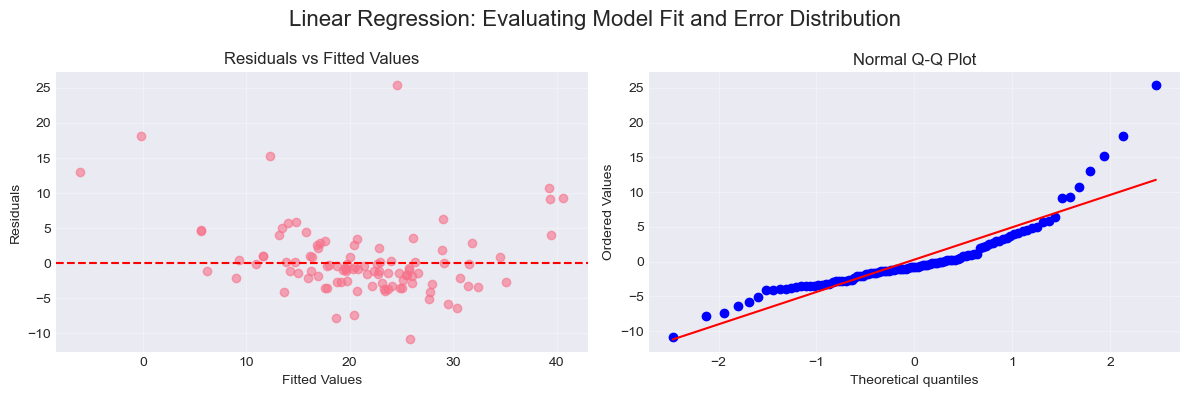

In [ ]:
# Residual analysis
residuals = y_test - y_test_pred

#  Normality of residuals (Shapiro-Wilk test)

stat, p_value = stats.shapiro(residuals)
print(f"1. NORMALITY TEST (Shapiro-Wilk):")
print(f"   Test statistic: {stat:.4f}")
print(f"   P-value: {p_value:.4f}")

print('\n')

print(f"   Mean of residuals: {residuals.mean():.4f}")
print(f"   Std of residuals: {residuals.std():.4f}")

# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residuals vs Fitted
axes[0].scatter(y_test_pred, residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot')
axes[1].grid(True, alpha=0.3)

fig.suptitle('Linear Regression: Evaluating Model Fit and Error Distribution', fontsize=16)
plt.tight_layout()
plt.savefig('assumption_checks.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: assumption_checks.png")


## 4. Non-Parametric Regression: KNeighborsRegressor

Unlike Linear Regression, KNN does **not assume any specific functional form** between predictors and the target variable.  

Instead, it makes predictions based on the **average value of the K nearest training samples** in the feature space, 

using a distance metric (typically Euclidean distance).

### Evaluating KNN Across Different Values of K

To analyze how model complexity affects performance, we train and evaluate KNN for a range of neighborhood sizes:

```python
k_values = [1, 2, 3, 5, 7, 10, 15, 20, 30, 50, 75, 100]

In [ ]:
k_values = [1, 2, 3, 5, 7, 10, 15, 20, 30, 50, 75, 100]
knn_results = []

print(f"{'K':<5} {'Train_MSE':<12} {'Test_MSE':<12} {'Train_R2':<10} {'Test_R2':<10}")
print("-" * 60)

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    y_train_pred_knn = knn.predict(X_train_scaled)
    y_test_pred_knn = knn.predict(X_test_scaled)
    
    train_mse_knn = mean_squared_error(y_train, y_train_pred_knn)
    test_mse_knn = mean_squared_error(y_test, y_test_pred_knn)
    train_r2_knn = r2_score(y_train, y_train_pred_knn)
    test_r2_knn = r2_score(y_test, y_test_pred_knn)
    
    knn_results.append({
        'K': k,
        'Train_MSE': train_mse_knn,
        'Test_MSE': test_mse_knn,
        'Train_R2': train_r2_knn,
        'Test_R2': test_r2_knn
    })
    
    print(f"{k:<5} {train_mse_knn:<12.4f} {test_mse_knn:<12.4f} "
          f"{train_r2_knn:<10.4f} {test_r2_knn:<10.4f}")

knn_df = pd.DataFrame(knn_results)

# pick best K by Test MSE
optimal_idx = knn_df['Test_MSE'].idxmin()
optimal_k = knn_df.loc[optimal_idx, 'K']
optimal_test_mse = knn_df.loc[optimal_idx, 'Test_MSE']
optimal_test_r2 = knn_df.loc[optimal_idx, 'Test_R2']

print("\n4.2 Optimal K")
print("-" * 40)
print(f"Optimal K: {optimal_k}")
print(f"Test MSE at optimal K: {optimal_test_mse:.4f}")
print(f"Test R² at optimal K:  {optimal_test_r2:.4f}")

results['KNN'] = {
    'features': X_train.shape[1],
    'train_mse': knn_df.loc[optimal_idx, 'Train_MSE'],
    'test_mse': optimal_test_mse,
    'train_r2': knn_df.loc[optimal_idx, 'Train_R2'],
    'test_r2': optimal_test_r2,
}

K     Train_MSE    Test_MSE     Train_R2   Test_R2   
------------------------------------------------------------
1     0.0000       24.9096      1.0000     0.6603    
2     5.1662       16.1115      0.9405     0.7803    
3     7.9215       19.4043      0.9088     0.7354    
5     13.0403      20.6055      0.8499     0.7190    
7     17.5485      23.4155      0.7980     0.6807    
10    19.7759      24.8342      0.7724     0.6614    
15    20.5121      26.1870      0.7639     0.6429    
20    22.0159      26.8487      0.7466     0.6339    
30    25.8164      30.3192      0.7028     0.5866    
50    32.3522      34.6439      0.6276     0.5276    
75    38.3714      37.2432      0.5583     0.4921    
100   42.2006      37.7106      0.5142     0.4858    

4.2 Optimal K
----------------------------------------
Optimal K: 2
Test MSE at optimal K: 16.1115
Test R² at optimal K:  0.7803



 KNN: Training vs Test Error Plot
----------------------------------------
✓ Saved: knn_train_test_mse.png

 Linear vs KNN (Original Features)
----------------------------------------
                   Method  Features  Train_MSE  Test_MSE  Test-Train Gap  Test_R²
   Linear (full features)        13    21.6414   24.2911          2.6497   0.6688
LinearR Selected Features        10    21.8655   25.5002          3.6348   0.6523
                      KNN        13     5.1662   16.1115         10.9453   0.7803


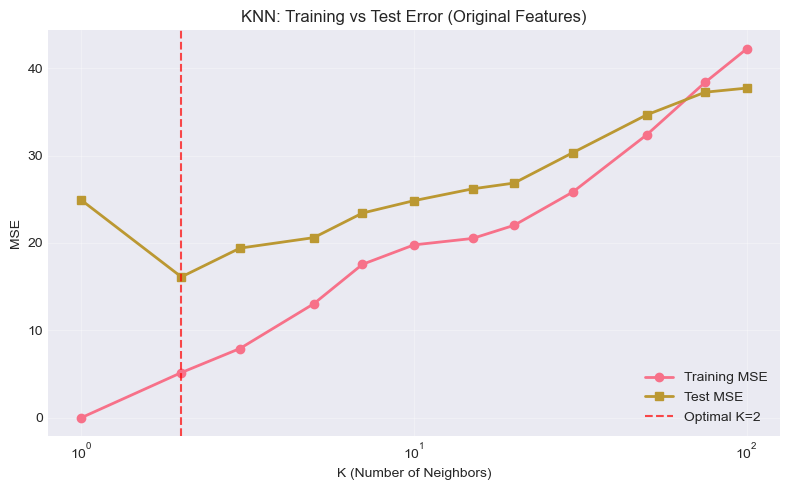

In [ ]:
# KNN Training vs Test Error Plot
print("\n KNN: Training vs Test Error Plot")
print("-" * 40)

plt.figure(figsize=(8, 5))
plt.plot(knn_df['K'], knn_df['Train_MSE'], 'o-', label='Training MSE',
         linewidth=2, markersize=6)
plt.plot(knn_df['K'], knn_df['Test_MSE'], 's-', label='Test MSE',
         linewidth=2, markersize=6)
plt.axvline(optimal_k, color='red', linestyle='--', alpha=0.7,
            label=f'Optimal K={optimal_k}')
plt.xscale('log')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('MSE')
plt.title('KNN: Training vs Test Error (Original Features)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('knn_train_test_mse.png', dpi=300, bbox_inches='tight')
print("✓ Saved: knn_train_test_mse.png")

# Comparison table
print("\n Linear vs KNN (Original Features)")
print("-" * 40)

study1_table = pd.DataFrame({
    'Method': [
        'Linear (full features)',
        'LinearR Selected Features',
        'KNN'
    ],
    'Features': [
        results['Linear (full features)']['features'],
        results['LinearR Selected Features']['features'],
        results['KNN']['features']
    ],
    'Train_MSE': [
        results['Linear (full features)']['train_mse'],
        results['LinearR Selected Features']['train_mse'],
        results['KNN']['train_mse']
    ],
    'Test_MSE': [
        results['Linear (full features)']['test_mse'],
        results['LinearR Selected Features']['test_mse'],
        results['KNN']['test_mse']
    ],
    'Test-Train Gap': [
        results['Linear (full features)']['test_mse'] - results['Linear (full features)']['train_mse'],
        results['LinearR Selected Features']['test_mse'] - results['LinearR Selected Features']['train_mse'],
        results['KNN']['test_mse'] - results['KNN']['train_mse']
    ],
    'Test_R²': [
        results['Linear (full features)']['test_r2'],
        results['LinearR Selected Features']['test_r2'],
        results['KNN']['test_r2']
    ]
}).round(4)

print(study1_table.to_string(index=False))


### Reflection Questions

1. **Why might KNN outperform or underperform compared to Linear Regression?**

2. **Is there evidence of heteroscedasticity or non-linearity?** 

3. **How might these findings affect the reliability of your linear model?**

4. **Which model is more prone to overfitting?**